# csaQTL GWAS in HipSci dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cna, pickle, os, pp 
from matplotlib import lines
from matplotlib.patches import ConnectionPatch
from figure_functions import *
gw_sig = 5e-08

res_folder = "/data/srlab/lrumker/MCSC_Project/cna-qtl/results/"
fig_dir = "/data/srlab/lrumker/MCSC_Project/cna-qtl/figs/"

# From Okabe & Ito, "colorblind-friendly" palette 
from matplotlib.colors import LinearSegmentedColormap
color_dict = {'orange': '#E69F00', 'skyblue': '#56B4E9', 'green': '#009E73', 
              'yellow': '#F0E442', 'purple': '#CC79A7', 'oceanblue': '#0072B2', 
              'vermillion': '#E63d00'} # O&I use '#D55E00'

## Manhattan plot

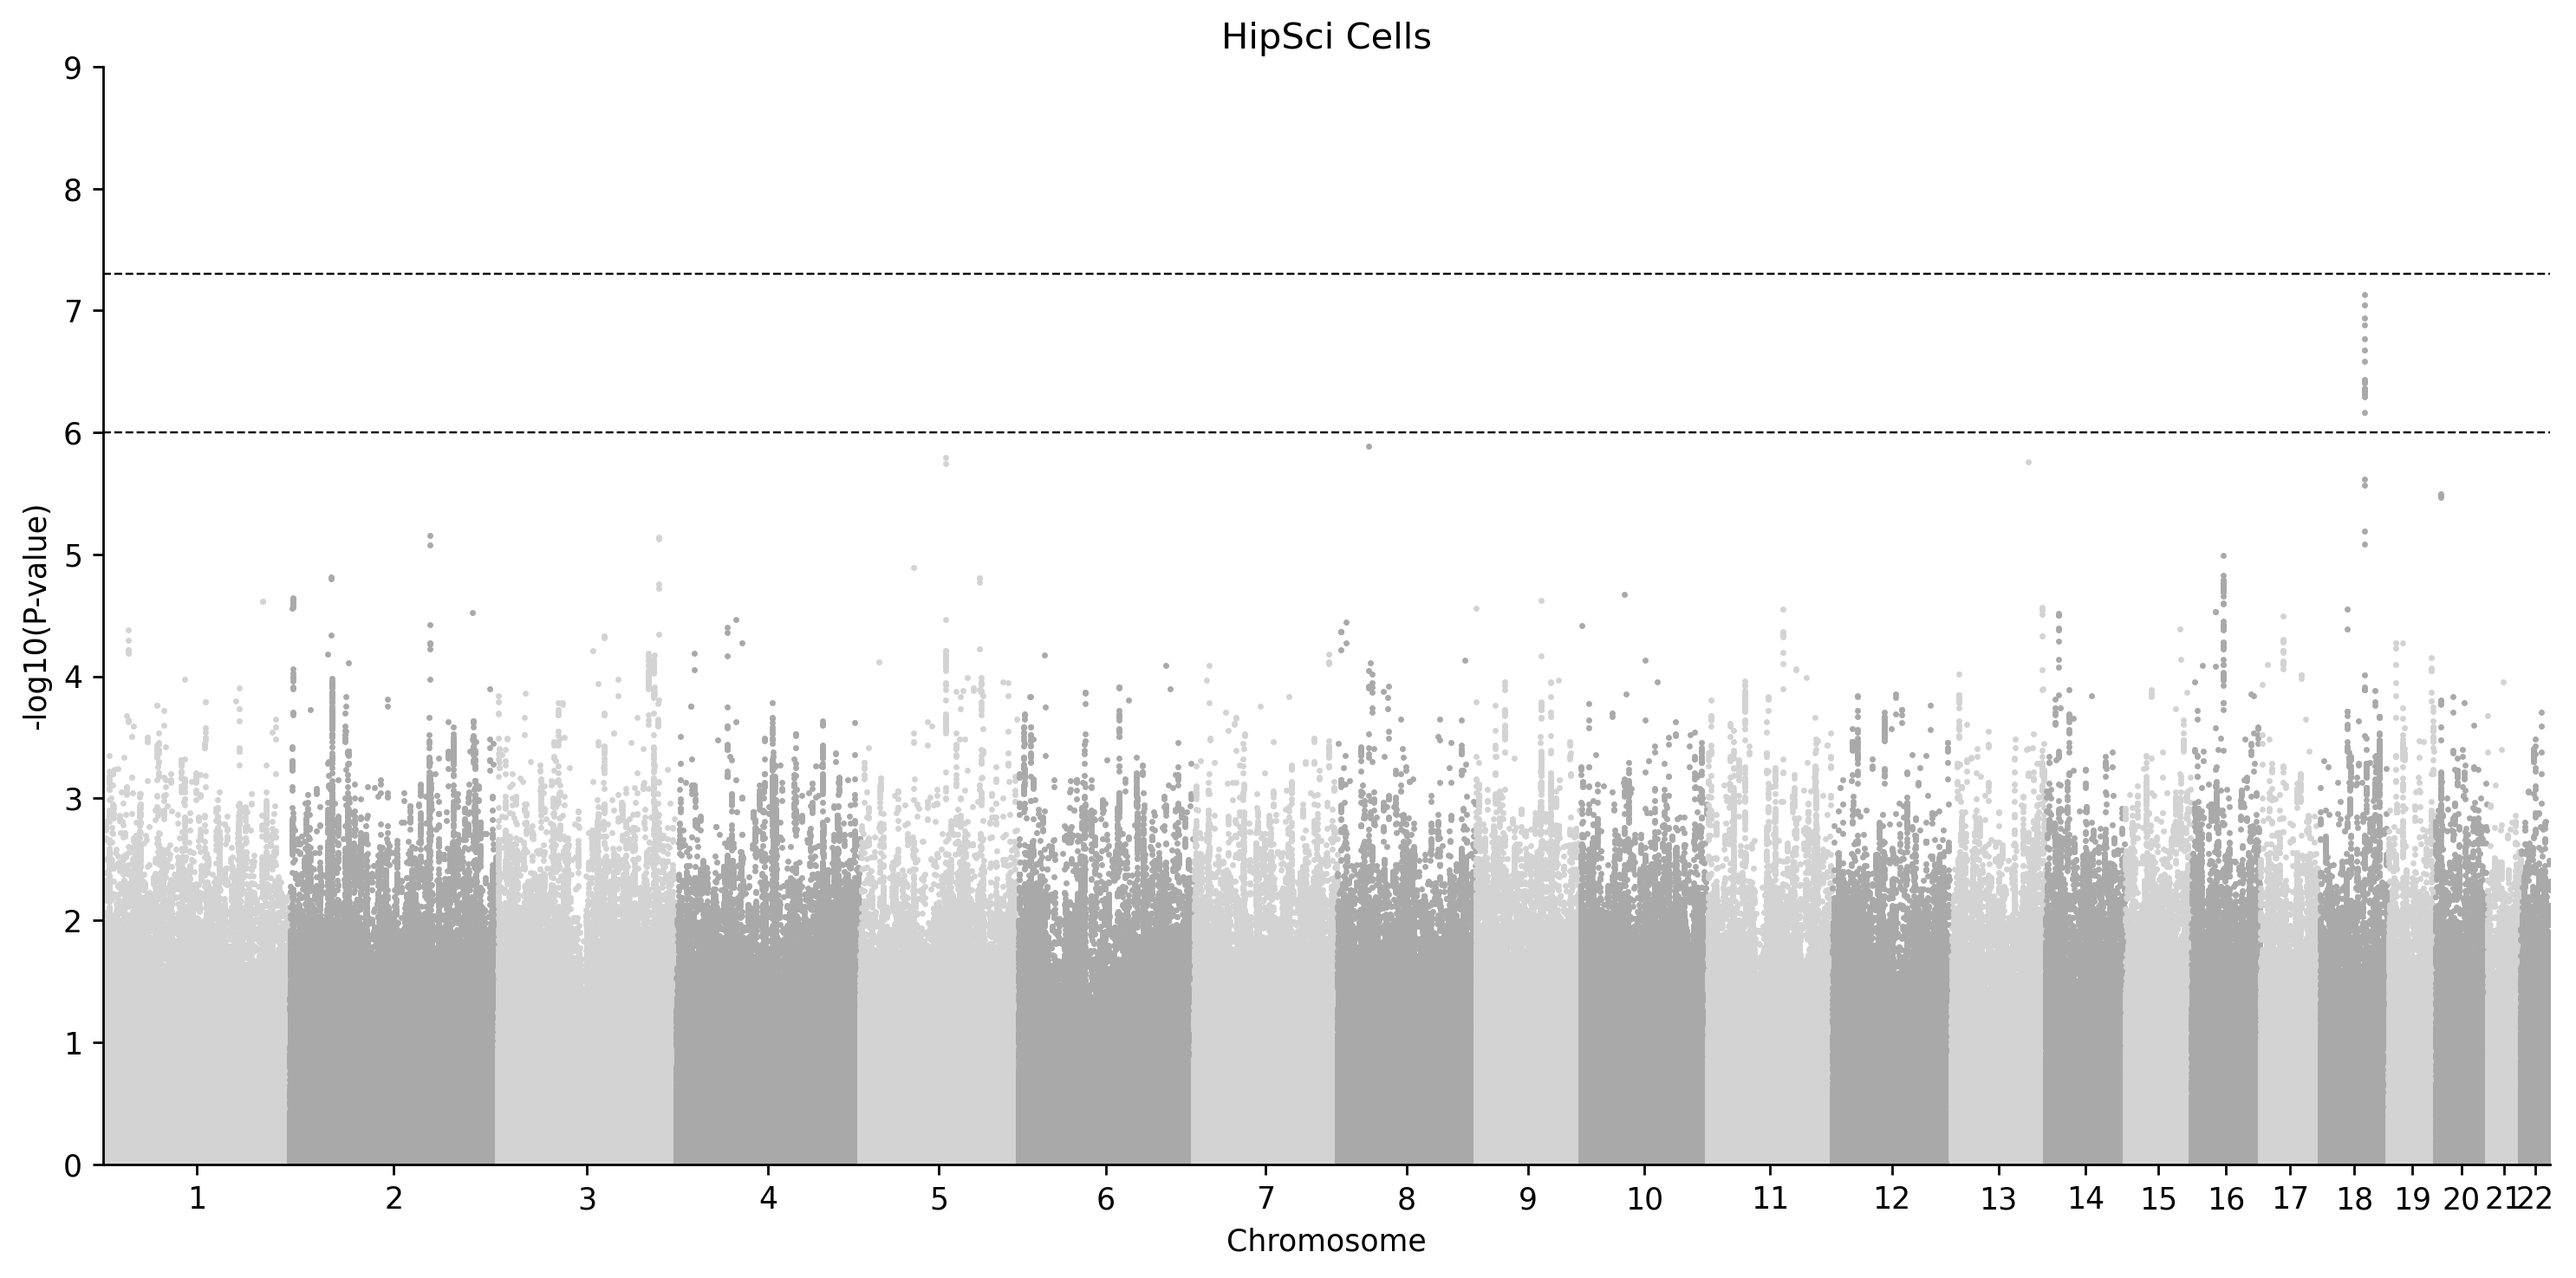

In [2]:
celltypes = ["HipSci"]

for i in np.arange(len(celltypes)):
    celltype = celltypes[i]
    
    # Load gwas results
    res = pd.read_csv(res_folder+"gwas_"+celltype+"/GeNA_sumstats.txt", sep = "\t")
    reordered_res = pd.DataFrame({})
    for sel_chr in np.arange(1,23):
        sub_res = res.loc[res['#CHROM']==sel_chr,:].reset_index(drop=True)
        sub_res = sub_res.iloc[np.argsort(sub_res['POS']),:]
        reordered_res = pd.concat([reordered_res, sub_res])
    res = reordered_res
    
    res['log10p'] = -np.log10(res['P'])
    res['ind'] = range(res.shape[0])
    res_grouped = res.groupby(('#CHROM'))
    res = res.astype({'#CHROM':'string'})

    # Generate plot
    fig = plt.figure(figsize=(12, 6), dpi = 250) # Set the figure size
    ax = fig.add_subplot(111)
    colors = ['lightgrey', 'darkgrey']
    x_labels = []
    x_labels_pos = []
    for num, (name, group) in enumerate(res_grouped):
        group.plot(kind='scatter', x='ind', y='log10p',color=colors[num % len(colors)], ax=ax, s=1, rasterized = True)
        x_labels.append(name)
        x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))
    ax.set_xticks(x_labels_pos)
    ax.set_xticklabels(x_labels)
    
    res.loc[res.P.values < gw_sig,:].plot(kind='scatter', x='ind', y='log10p',
       color=color_dict['green'], ax=ax, s=5, rasterized = True)

    # set axis limits
    ax.set_xlim([0, len(res)])
    ax.set_ylim([0, np.max([8,np.ceil(np.max(res.log10p))+1])])

    # x axis label
    ax.set_xlabel('Chromosome')
    ax.set_ylabel('-log10(P-value)')

    # Add p-value thresholds
    ax.axhline(y=-np.log10(gw_sig), linestyle="--", color = "black", lw=0.7)
    ax.axhline(y=-np.log10(1e-6), linestyle="--", color = "black", lw=0.7)

    # remove top / right spines
    ax.spines[['right', 'top']].set_visible(False)
    
    if celltype=="allcells":
        plt.title("All Cells")
    else:
        plt.title(celltype+" Cells")
    plt.tight_layout()
    plt.savefig(fig_dir+"gwas_"+celltype+".png", dpi = 300, transparent=True)
    plt.show()

# csaQTL-associated phenotype for suggestive locus

In [3]:
res = pickle.load(open("/data/srlab/lrumker/MCSC_Project/cna-qtl/results/gwas_HipSci/cna_res_18:54746518.p",'rb'))

In [4]:
d = cna.read("/data/srlab/lrumker/datasets/HipSci/pheno/HipSci.h5ad")

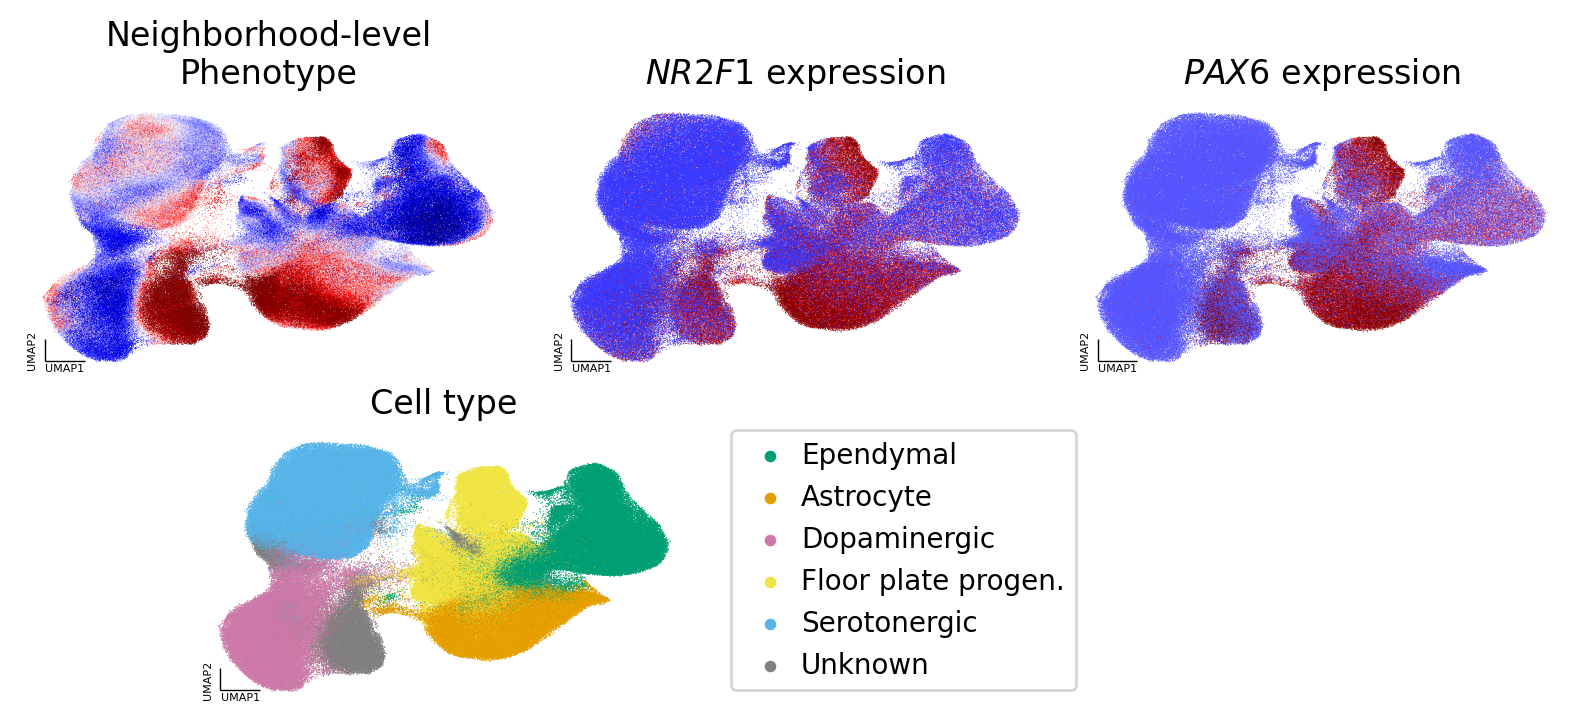

In [5]:
fig = plt.figure(figsize = (10,4), dpi = 200)
gs = GridSpec(2, 9)
ax1 = fig.add_subplot(gs[:-1, 0:3])
ax2 = fig.add_subplot(gs[:-1, 3:6])
ax3 = fig.add_subplot(gs[:-1, 6:9])
ax4 = fig.add_subplot(gs[-1, 1:4])

ax = ax1
pp.scatter_random(d.obsm['X_umap'][:,0], d.obsm['X_umap'][:,1], s = 0.5, 
                  c = res.ncorrs, cmap='seismic', ax = ax)
ax.axis("off")
ax.set_title("Neighborhood-level\nPhenotype")

ax = ax4
plot_colors = np.repeat("#808080", d.obs.shape[0])
mask = np.logical_or(d.obs.celltype=="Epen1", d.obs.celltype=="Epen2")
plot_colors[mask] = color_dict["green"]
mask = d.obs.celltype=="Astro"
plot_colors[mask] = color_dict["orange"]
mask = d.obs.celltype=="DA"
plot_colors[mask] = color_dict["purple"]
mask = np.logical_or(d.obs.celltype=="FPP", d.obs.celltype=="P_FPP")
plot_colors[mask] = color_dict["yellow"]
mask = np.logical_or(d.obs.celltype=="Sert", d.obs.celltype=="P_Sert")
plot_colors[mask] = color_dict["skyblue"]
pp.scatter_random(d.obsm['X_umap'][:,0], d.obsm['X_umap'][:,1], s = 0.5, ax = ax,
            c = np.array(plot_colors), symmetrize=False)

ax.scatter(d.obsm['X_umap'][0,0], d.obsm['X_umap'][0,1], s = 0.001,
            c = color_dict["green"], label = "Ependymal")
ax.scatter(d.obsm['X_umap'][0,0], d.obsm['X_umap'][0,1], s = 0.001,
            c = color_dict["orange"], label = "Astrocyte")
ax.scatter(d.obsm['X_umap'][0,0], d.obsm['X_umap'][0,1], s = 0.001,
            c = color_dict["purple"], label = "Dopaminergic")
ax.scatter(d.obsm['X_umap'][0,0], d.obsm['X_umap'][0,1], s = 0.001,
            c = color_dict["yellow"], label = "Floor plate progen.")
ax.scatter(d.obsm['X_umap'][0,0], d.obsm['X_umap'][0,1], s = 0.001,
            c = color_dict["skyblue"], label = "Serotonergic")
ax.scatter(d.obsm['X_umap'][0,0], d.obsm['X_umap'][0,1], s = 0.001,
            c = "#808080", label = "Unknown")
pp.scatter_random(d.obsm['X_umap'][:,0], d.obsm['X_umap'][:,1], s = 0.5, ax = ax,
            c = np.array(plot_colors), symmetrize=False)

ax.axis("off")
ax.legend(loc="lower left", markerscale=100, handletextpad=0.1, bbox_to_anchor=(1.05, 0))
ax.set_title("Cell type")

ax = ax2
sel_gene = "NR2F1"
i_gene = np.where(d.var.index==sel_gene)[0][0]
pp.scatter_random(d.obsm['X_umap'][:,0], d.obsm['X_umap'][:,1], c = d.X[:,i_gene], cmap = "seismic", ax = ax)
ax.axis("off")
ax.set_title("$"+sel_gene+"$ expression")
    
ax = ax3
sel_gene = "PAX6"
i_gene = np.where(d.var.index==sel_gene)[0][0]
pp.scatter_random(d.obsm['X_umap'][:,0], d.obsm['X_umap'][:,1], c = d.X[:,i_gene], cmap = "seismic", ax = ax)
ax.axis("off")
ax.set_title("$"+ sel_gene+"$ expression")

for ax in [ax1, ax2, ax3, ax4]:
    add_umap_axes(ax, umap_axis_length = 0.08, umap_axis_offset = 0.0, 
              axis_lw = 0.5, umap_text_size = 4)

plt.savefig(fig_dir+"HipSci_csaQTL_chr18.png")
plt.show()

In [6]:
# Astro: Astrocyte-like
# DA: Dopaminergic Neurons
# FPP: Floor Plate Progenitors (FPP)
# P_FPP: Proliferating Floor Plate Progenitors
# ?Neuroblasts
# Sert: Serotonergic-like neurons
# P_Sert: Proliferating Sert, 
# Epen: Ependymal-like (Epen) 1, 2
# Unknown_Neur1, 2, 3
d.obs.loc[mask,:].celltype.value_counts()

Sert       114050
P_Sert       2321
Astro           0
DA              0
Epen1           0
Epen2           0
FPP             0
P_FPP           0
U_Neur1         0
U_Neur3         0
Name: celltype, dtype: int64

In [7]:
#lead SNP 18:54746518:C:T (hg19) 7.4e-08 rs11875802

In [8]:
res.vargene_cors.iloc[np.argsort(-np.abs(res.vargene_cors.cor)),:].head(10)

,gene,cor
596,NR2F1,0.483216
746,FABP7,0.470673
1037,BAALC,0.460359
1236,PAX6,0.456905
875,PTN,0.434471
864,FEZF1,0.428164
751,RSPO3,0.417178
663,TUBB2B,0.404937
463,IGFBP7,-0.390725
831,GNG11,0.389932
